# Lab 7: Time-series Anomaly Detection



Pandas was updated on 03/04/2023 to version 2.0, which is not compatibile with tsfel. Dowgrade to 1.5.3

In [ ]:
!pip install pandas==1.5.3
!pip install tsfel
!pip install keras_tuner

## Import and settings

In [3]:
import os
import time
import tsfel
import warnings
import datetime
import keras_tuner
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
from sklearn import metrics
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import preprocessing
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score

ROOTDIR_DATASET_NORMAL = "/content/drive/MyDrive/MLA_Dati/Kuka_v1/normal"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Utils

In [6]:
def seaborn_cm(cm, ax, tick_labels, fontsize=14, title=None, sum_actual="over_columns",
               xrotation=0, yrotation=0):
    """
    Function to plot a confusion matrix
    """
    from matplotlib import cm as plt_cmap
    group_counts = ["{:0.0f}".format(value) for value in cm.flatten()]
    if sum_actual == "over_columns":
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    elif sum_actual == "over_rows":
        cm = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis]
    else:
        print("sum_actual must be over_columns or over_rows")
        exit()
    cm = np.nan_to_num(cm)
    mean_acc = np.mean(np.diag(cm)[cm.sum(axis=1) != 0])
    std_acc = np.std(np.diag(cm))
    group_percentages = ["{:0.0f}".format(value*100) for value in cm.flatten()]
    cm_labels = [f"{c}\n{p}%" for c, p in zip(group_counts, group_percentages)]
    cm_labels = np.asarray(cm_labels).reshape(len(tick_labels), len(tick_labels))
    sns.heatmap(cm,
                ax=ax,
                annot=cm_labels,
                fmt='',
                cbar=False,
                cmap=plt_cmap.Greys,
                linewidths=1, linecolor='black',
                annot_kws={"fontsize": fontsize},
                xticklabels=tick_labels,
                yticklabels=tick_labels)
    ax.set_yticklabels(ax.get_yticklabels(), size=fontsize, rotation=yrotation)
    ax.set_xticklabels(ax.get_xticklabels(), size=fontsize, rotation=xrotation)
    if title:
        title = f"{title}\nMean accuracy {mean_acc * 100:.1f} +- {std_acc * 100:.1f}"
    else:
        title = f"Mean accuracy {mean_acc * 100:.1f} +- {std_acc * 100:.1f}"
    ax.set_title(title)
    if sum_actual == "over_columns":
        ax.set_ylabel("Actual")
        ax.set_xlabel("Predicted")
    else:
        ax.set_ylabel("Predicted")
        ax.set_xlabel("Actual")
    ax.axis("off")

# Introduction

You will use the dataset provided in the first Lab, concerning time series.

In such Lab1, we built a model able to classify the action that is performing a Kuka robot.

Now, we will explore Time Series Anomaly Detection (TAD), hence considering also the data contained in the collinsion foder.

This function loads sensor readings and the correspondig metadata.
The output is a dataframe grouped by action.

In [7]:
def get_df_action(filepaths_csv, filepaths_meta, action2int=None, delimiter=";"):
    # Load dataframes
    print("Loading data.")
    # Make dataframes
    # Some classes show the output boolean parameter as True rather than true. Fix here
    dfs_meta = list()
    for filepath in filepaths_meta:
        df_m = pd.read_csv(filepath, sep=delimiter)
        df_m.str_repr = df_m.str_repr.str.replace('True', 'true')
        df_m['filepath'] = filepath
        dfs_meta.append(df_m)

    df_meta = pd.concat(dfs_meta)
    df_meta.index = pd.to_datetime(df_meta.init_timestamp.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
    df_meta['completed_timestamp'] = pd.to_datetime(df_meta.completed_timestamp.astype('datetime64[ms]'),
                                                    format="%Y-%m-%dT%H:%M:%S.%f")
    df_meta['init_timestamp'] = pd.to_datetime(df_meta.init_timestamp.astype('datetime64[ms]'),
                                               format="%Y-%m-%dT%H:%M:%S.%f")

    # Eventually reduce number of classes
    # df_meta['str_repr'] = df_meta.str_repr.str.split('=', expand = True,n=1)[0]
    # df_meta['str_repr'] = df_meta.str_repr.str.split('(', expand=True, n=1)[0]

    actions = df_meta.str_repr.unique()
    dfs = [pd.read_csv(filepath_csv, sep=";") for filepath_csv in filepaths_csv]
    df = pd.concat(dfs)

    # Sort columns by name !!!
    df = df.sort_index(axis=1)

    # Set timestamp as index
    df.index = pd.to_datetime(df.time.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
    # Drop useless columns
    columns_to_drop = [column for column in df.columns if "Abb" in column or "Temperature" in column]
    df.drop(["machine_nameKuka Robot_export_active_energy",
             "machine_nameKuka Robot_import_reactive_energy"] + columns_to_drop, axis=1, inplace=True)
    signals = df.columns

    df_action = list()
    for action in actions:
        for index, row in df_meta[df_meta.str_repr == action].iterrows():
            start = row['init_timestamp']
            end = row['completed_timestamp']
            df_tmp = df.loc[start: end].copy()
            df_tmp['action'] = action
            # Duration as string (so is not considered a feature)
            df_tmp['duration'] = str((row['completed_timestamp'] - row['init_timestamp']).total_seconds())
            df_action.append(df_tmp)
    df_action = pd.concat(df_action, ignore_index=True)
    df_action.index = pd.to_datetime(df_action.time.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
    df_action = df_action[~df_action.index.duplicated(keep='first')]

    # Drop NaN
    df = df.dropna(axis=0)
    df_action = df_action.dropna(axis=0)

    if action2int is None:
        action2int = dict()
        j = 1
        for label in df_action.action.unique():
            action2int[label] = j
            j += 1

    df_merged = df.merge(df_action[['action']], left_index=True, right_index=True, how="left")
    # print(f"df_merged len: {len(df_merged)}")
    # Where df_merged in NaN Kuka is in idle state
    df_idle = df_merged[df_merged['action'].isna()].copy()
    df_idle['action'] = 'idle'
    df_idle['duration'] = df_action.duration.values.astype(float).mean().astype(str)
    df_action = pd.concat([df_action, df_idle])

    # ile label must be 0 for debug mode
    action2int['idle'] = 0
    print(f"Found {len(set(df_action['action']))} different actions.")
    print("Loading data done.\n")

    return df_action, df, df_meta, action2int

Load all data (and metadata) for frequency = 10 Hz for the normal time series

In [ ]:
!ls {ROOTDIR_DATASET_NORMAL}

In [ ]:
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_0.1s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_0.1s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

In [ ]:
df_action.head(2)

# Features extraction

We will leverage [Time Series Feature Extraction Library (TSFEL)](https://tsfel.readthedocs.io/en/latest/), to extract features from time series data.

In [11]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

def get_features_ts(domain, df_action, df_meta, frequency, action2int):
    duration_dict = {1: 10, 10: 1, 100: 0.1, 200: 0.05}
    duration_min = duration_dict[int(frequency)]
    cfg = tsfel.get_features_by_domain(domain)
    dataframe_features = list()
    print("Computing features.")
    # Idle does not have associated timestamps. Window is set to 10 seconds
    df_by_action = df_action[df_action["action"] == "idle"].copy()
    X = tsfel.time_series_features_extractor(cfg,
                                             df_by_action.select_dtypes(['number']),
                                             fs=frequency,
                                             header_names=df_by_action.select_dtypes(['number']).columns + '-',
                                             window_size=int(frequency * 10),
                                             verbose=False)
    time = pd.to_datetime(df_by_action.time.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
    X['start'] = [t[0] for t in
                  tsfel.utils.signal_processing.signal_window_splitter(time, window_size=int(frequency * 10))]
    X['duration'] = 10
    X['end'] = X['start'] + pd.to_timedelta(X['duration'], 's')
    X['label'] = action2int["idle"]
    X.drop('duration', inplace=True, axis=1)
    dataframe_features.append(X)
    actions = list(df_action.action.unique())
    actions.remove("idle")
    for action in actions:
        df_by_action = df_action[df_action["action"] == action].copy()
        df_meta_by_action = df_meta[df_meta['str_repr'] == action].copy()
        df_meta_by_action['start'] = pd.to_datetime(df_meta_by_action.init_timestamp.astype('datetime64[ms]'),
                                                    format="%Y-%m-%dT%H:%M:%S.%f")
        df_meta_by_action['end'] = pd.to_datetime(
            df_meta_by_action.completed_timestamp.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
        for _, row in df_meta_by_action.iterrows():
            df_by_action_by_event = df_by_action.loc[row["start"]: row["end"]]
            if len(df_by_action_by_event) < duration_min * frequency:
                print(f"Skipped feature extraction for {action} {row['start']} : {row['end']}.")
                continue

            X = tsfel.calc_window_features(cfg,
                                           df_by_action_by_event.select_dtypes(['number']),
                                           header_names=df_by_action_by_event.select_dtypes(['number']).columns + '-',
                                           fs=frequency,
                                           verbose=False)
            # print(X.shape)
            X['label'] = action2int[action]
            X['start'] = row['start']
            X['end'] = row['end']
            dataframe_features.append(X)

    dataframe_features = pd.concat(dataframe_features)
    print("Computing features done.")
    return dataframe_features

In [ ]:
start_time = time.time()
df_features = get_features_ts("statistical", df_action, df_meta, 10, action2int)
print("--- %s seconds ---" % (time.time() - start_time))

Prepare data for train and test

Note that:

*   the last three columns are the start, the end and the label corresponding to the action the robot is performing. Label is our gound truth, start and end can be dropped for the moment.
*   set NaN valuesto 0.




In [ ]:
df_features.isnull().values.any()

In [14]:
df_features_nonan = df_features.fillna(0)     # c'è zero al posto del drop della colonna altrimenti si potrebbero avere problemi
                                              # nel processare i dati anomali (o normali, non si è capito)

In [15]:
df_train, df_test = train_test_split(df_features_nonan)

In [16]:
X_train = df_train.drop(["label", "start", "end"], axis=1)
y_train = df_train["label"]
X_test = df_test.drop(["label", "start", "end"], axis=1)
y_test = df_test["label"]

In [17]:
# Normalise features
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

# Remove zero-variance features
selector_variance = VarianceThreshold()
selector_variance.fit(X_train)
X_train = pd.DataFrame(selector_variance.transform(X_train),
                        columns=X_train.columns.values[selector_variance.get_support()])

# Remove highly correlated features
corr_features = tsfel.correlated_features(X_train,
                                          threshold=0.95)
X_train.drop(corr_features, inplace=True, axis=1)

# Lasso selector
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
lasso = SelectFromModel(lsvc, prefit=True)
selected_features = X_train.columns.values[lasso.get_support()]
X_train = X_train[selected_features].copy()

# Labels
num_classes = len(set(y_train))
y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)

# Test
X_test = pd.DataFrame(selector_variance.transform(scaler.transform(X_test)),
                      columns=X_test.columns.values[selector_variance.get_support()])
X_test.drop(corr_features, inplace=True, axis=1)
X_test = X_test[selected_features].copy()

# Assignment #1: Train a Bayesian MLP

Here we will train a Bayesian MLP able to provide a reliable uncertainty metric.
We will use [keras tuner](https://keras.io/keras_tuner/) to tune the huperparameters of such model.

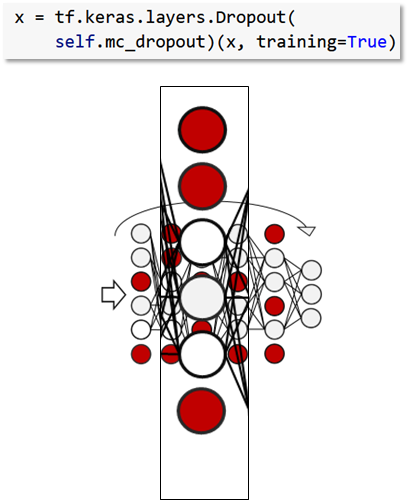

In [ ]:
# La confidence della predizione sulle azioni è usata come per determinare se in quella finestra temporale (ottenuta tramite TSFEL) c'è
# un'anomalia oppure no. Questo è fatto in funzione di una threshold. In questo caso, il task di classificazione delle azioni è SOLO un
# task di "pretesto", non ci interessa davvero; lo usiamo appunto come un pretesto per ottenere conoscenza su un task diverso. Questo
# è un caso di self-supervised learning (la label è ottenuta tramite la classificazione e poi la confidenza)

In [ ]:
X_train, X_val, y_train_categorical, y_val_categorical = train_test_split(np.array(X_train), np.array(y_train_categorical), test_size=0.2, random_state=42)

In [ ]:
# Molto semplice e con modello sequenziale. Non puoi creare mettere il training del dropout a true con il modello sequenziale
# Create the MLP tf model
def build_model(hp):                                        # hp sta per hyperparameters
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(
        hp.Choice('units_1', [64, 128, 256, 512]),          # il numero di neuroni del primo hidden layer
        activation='relu'))
    model.add(tf.keras.layers.Dropout(.5, training=True))   # questo non si può fare, il modello deve essere sequenziale
    model.add(tf.keras.layers.Dense(
        hp.Choice('units_2', [32, 64, 128]),                # il numero di neuroni del secondo hidden layer
        activation='relu'))
    model.add(tf.keras.layers.Dropout(.5, training=True))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    hp_learning_rate = hp.Choice('learning_rate', [0.001, 0.01, 0.1])
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=hp_learning_rate),
                  metrics=["accuracy"],
                  loss=tf.keras.losses.CategoricalCrossentropy())
    return model

In [19]:
# Molto semplice e con modello funzionale.
# Create the MLP tf model
def build_model(hp):
    input_layer = tf.keras.layers.Input(shape=(X_train.shape[1]))
    x = tf.keras.layers.Dense(
        hp.Choice('units_1', [64, 128, 256, 512]),          # il numero di neuroni del primo hidden layer
        activation='relu')(input_layer)
    x = tf.keras.layers.Dropout(.5)(x, training=True)
    x = tf.keras.layers.Dense(
        hp.Choice('units_2', [32, 64, 128]),                # il numero di neuroni del secondo hidden layer
        activation='relu')(x)
    x = tf.keras.layers.Dropout(.5)(x, training=True)
    y = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    tf_model = tf.keras.models.Model(inputs=input_layer, outputs=y)
    hp_learning_rate = hp.Choice('learning_rate', [0.001, 0.01, 0.1])
    tf_model.compile(optimizer=tf.optimizers.Adam(learning_rate=hp_learning_rate),
                  metrics=["accuracy"],
                  loss=tf.keras.losses.CategoricalCrossentropy())
    return tf_model

In [ ]:
# Più articolato e con il modello funzionale. E' molto figo
def build_model(hp):
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])          # Choice: fornisci una lista di valori
    hp_drop_rate = hp.Float('drop_rate', min_value=0.1, max_value=0.75, step=32)      # Float: valori float da min a max con step
    hp_drp_rate_last = hp.Float('drop_rate', min_value=0.1, max_value=0.75, step=32)
    input_layer = tf.keras.layers.Input(shape=(X_train.shape[1]))                     # Obbligatorio per il modello funzionale
    x = input_layer
    for i in range (hp.Int('mpl_layers', 1, 3)):              # molto interessante
        x = tf.keras.layers.Dense(
              hp.Choice(f'units_{i}', [32, 64, 128, 256, 512]),
              activation='relu')(x)
        x = tf.keras.layers.Dropout(hp_drop_rate)(x, training=True)   # impostare qui il trainig a True è quello che mi permette di
    x = tf.keras.layers.Dropout(hp_drp_rate_last)(x, training=True)   # avere il meccanismo di drop out anche nel testing
    x = tf.keras.layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    tf_model = tf.keras.models.Model(inputs=input_layer, outputs=x)
    tf_model.compile(optimizer=tf.optimizers.Adam(learning_rate=hp_learning_rate),
                  metrics=["accuracy"],
                  loss=tf.keras.losses.CategoricalCrossentropy())
    return tf_model

In [20]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective="val_accuracy",                 # va inserito lo stesso valore della metrica
    max_trials=20)

# Hyperband è molto più avanzato di RandomSearch perché bilancia meglio exploration
# con exploitation il RandomSearch esplora random lo spazio di hyperparametri a disposizione

In [ ]:
tuner.search(X_train, y_train_categorical, epochs=150, validation_data=(X_val, y_val_categorical))
classifier = tuner.get_best_models()[0]
y_pred = classifier.predict(X_test, verbose=False)
# le performance potrebbero essere inferiori

In [ ]:
classifier.save('best_model')
classifier.save_weights(os.path.join('model_weights', 'pesi_del_modello'))

In [22]:
y_test = np.array(y_test)
y_pred = np.argmax(y_pred, axis=1)

Check the model performance

In [ ]:
print(accuracy_score(y_test, y_pred))
plt.figure(figsize = (10,10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 10})
plt.show()

Here we implement a wrapper to compute uncertainty metrics

In [24]:
class Confidence:
    def __init__(self, classifier):
        super(Confidence, self).__init__()
        self.model = classifier
        self._uncertainty_metrics = dict()
        self._uncertainty_metrics['entropy'] = self._entropy
        self._uncertainty_metrics['variance'] = self._variance
        self._uncertainty_metrics['max_softmax_response'] = self._max_softmax_response

    def call(self, inputs):
        return self.model(inputs)

    def uncertainty_metrics(self, multiple_preds):
        return {metric: self._compute_uncertainty(        # calcola tutte le metriche ed aggiorna il dizionario
            metric,
            multiple_preds) for metric in self._uncertainty_metrics.keys()}

    def _normalize(self, values):                         # metriche da 0 a 1
          return (values - tf.reduce_min(values))/(tf.reduce_max(values)-tf.reduce_min(values))

    def _compute_uncertainty(self, metric, multiple_preds):
        try:
            print("Done {}".format(metric))
            return self._normalize(
                self._uncertainty_metrics[metric](multiple_preds))
        except KeyError:
            print("{} not implemented.".format(metric))

    def predict_many_times(self, inputs, draws=2):
        return np.array([self.model.predict(inputs, verbose=0) for _ in range(draws)])         # predice draws volte

    def _avreage_prediction(self, multiple_preds):
        if len(multiple_preds.shape) >2:
          return np.mean(np.array(multiple_preds), axis = 0)                  # calcola la media delle predizioni per campione
        else:                                                                 # quindi la media sul numero di draws
          return multiple_preds

    def _entropy(self, multiple_preds):
        avg_preds = self._avreage_prediction(multiple_preds)                  # calcola l'entropia per ogni campione (asse 1,
        eps = 1e-5                                                            # abbiamo un campione per colonna)
        entropy = -1 * np.sum(avg_preds * np.log(avg_preds + eps), axis=1)    # le pi(x) vanno da 0 a 1, pertanto producono
        return entropy                                                        # un log negativo. Con -1 torna positivo

    def _variance(self, multiple_preds):
        avg_preds = self._avreage_prediction(multiple_preds)                  # la varianza sappiamo misurare il discostamento
        return np.var(avg_preds, axis=1)                                      # dal valore medio delle predizioni del campione

    def _max_softmax_response(self, multiple_preds):
        avg_preds = self._avreage_prediction(multiple_preds)                  # calcola il valore di softmax massimo ottenuto tra
        return np.max(avg_preds, axis=1)                                      # le predizioni del campione (ma già in avg)


In [ ]:
def anomaly_detection_metric(anomlay_start_timestamps, confidence, df_dataset, thresholds, less_than=True):
    "Actual is y axis"
    if not less_than:
        confidence = 1 - confidence

    sens = list()           # sembra una lista di recall
    spec = list()
    fpr = list()
    f1 = list()
    prec = list()
    cm_list = list()
    anomlay_indexes_dict = dict()
    acc_with_err = list()
    for threshold in thresholds:
        df_not_confident = df_dataset[confidence <= threshold]
        tp = 0                                                                # true positive per quella threshold
        anomaly_indexes = list()
        for anomaly in anomlay_start_timestamps:
            for index, row in df_not_confident.iterrows():                    # serve a restituire indice e riga dei non confident (anomalie)
                if anomaly >= row['start'] and anomaly <= row['end']:
                    anomaly_indexes.append(index)
                    tp += 1

        cm_anomaly = np.zeros((2,2))
        n_sample = len(df_dataset)
        n_not_collision = n_sample - len(anomlay_start_timestamps)
        n_detected = len(df_not_confident)

        fp = n_detected - tp
        fn = len(anomlay_start_timestamps) - tp
        tn = n_not_collision - fp
        tn1 = n_sample - n_detected - fn                  # vediamo se è come tn

        cm_anomaly[0, 0] = tn
        cm_anomaly[0, 1] = fp
        cm_anomaly[1, 0] = fn
        cm_anomaly[1, 1] = tp

        cm_list.append(cm_anomaly)
        recall = tp / (tp + fn)
        sens.append(recall)
        fpr.append(1 - tn /(tn + fp))
        precision = tp / (tp + fp)
        prec.append(precision)
        spec.append(tn /(tn + fp))
        try:
            f1.append(2 * tp / (2 * tp + fp + fn))
        except  ZeroDivisionError:
            f1.append(0)
        cm_anomaly_norm = cm_anomaly.astype('float') / cm_anomaly.sum(axis=1)[:, np.newaxis]
        acc_with_err.append( (np.mean(np.diag(cm_anomaly_norm)), np.std(np.diag(cm_anomaly_norm))) )
        anomlay_indexes_dict[threshold] = anomaly_indexes
    return sens, spec, fpr, f1, cm_list, anomlay_indexes_dict, acc_with_err, prec

Plot the distribution for correct and wrong predictions

In [ ]:
model_unc = Confidence(classifier)

multiple_preds_normal = model_unc.predict_many_times(X_test, draws=10)
print(multiple_preds_normal.shape)

In [ ]:
bayes_pred = multiple_preds_normal.mean(axis=0)
print(bayes_pred.shape)

In [ ]:
uncertainties_bayes = dict()
uncertainties_bayes['correct'] = model_unc.uncertainty_metrics(bayes_pred[bayes_pred.argmax(axis=1) == y_test])
uncertainties_bayes['wrong'] = model_unc.uncertainty_metrics(bayes_pred[bayes_pred.argmax(axis=1) != y_test])
uncertainties_bayes['all'] = model_unc.uncertainty_metrics(bayes_pred)

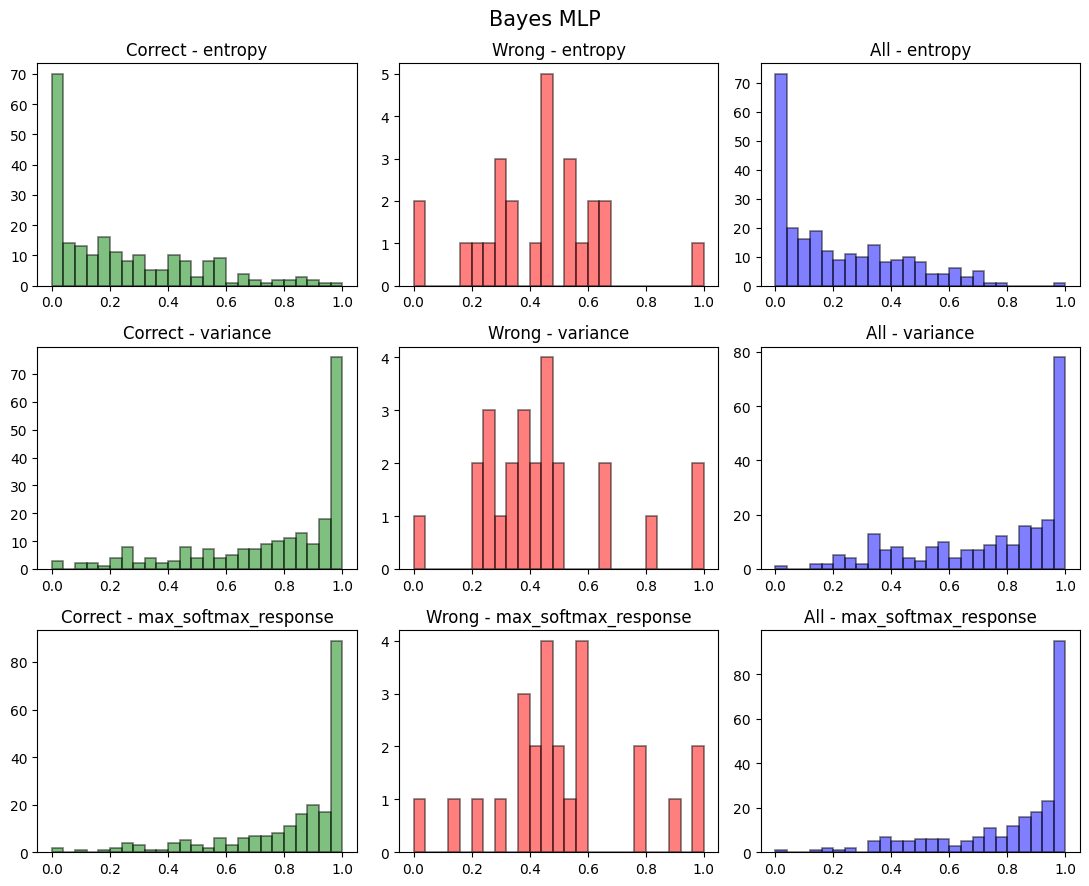

In [28]:
fig, ax = plt.subplots(len(model_unc._uncertainty_metrics.keys()), 3, figsize=(11, 9))
for ax, measure in zip(ax, model_unc._uncertainty_metrics.keys()):            # interessante
    ax[0].set_title(f"Correct - {measure}")
    ax[0].hist(uncertainties_bayes['correct'][measure], color="green", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5)
    ax[1].set_title(f"Wrong - {measure}")
    ax[1].hist(uncertainties_bayes['wrong'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5)
    ax[2].set_title(f"All - {measure}")
    ax[2].hist(uncertainties_bayes['all'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5)
fig.suptitle("Bayes MLP", fontsize=15)      # per mettere il titolo all'intera figura
plt.tight_layout()

# risulta dai grafici che l'incertezza maggiore la si ha per i samples negativi

# Load collisions and extract features

In [29]:
ROOTDIR_DATASET_ANOMALY = "/content/drive/MyDrive/MLA_Dati/Kuka_v1/collisions"

In [ ]:
!ls {ROOTDIR_DATASET_ANOMALY}

Note that we have a discrepancy between time in the lab where the data were collected and the PC which stored them. This line fix it.

In [31]:
collisions = pd.read_excel(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp.xlsx"))
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp - pd.to_timedelta([2] * len(collisions[collisions['Inizio/fine'] == "i"].Timestamp), 'h')

In [ ]:
filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_0.1s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_0.1s.metadata") for r in [1, 5]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

In [ ]:
start_time = time.time()
df_features_collision = get_features_ts("statistical", df_action, df_meta, 10, action2int)
print("--- %s seconds ---" % (time.time() - start_time))

Preprocessing

In [ ]:
df_features_collision.isnull().values.any()

In [37]:
df_features_collision_nonan = df_features_collision.fillna(0)

In [38]:
X_collision = df_features_collision_nonan.drop(["label", "start", "end"], axis=1)
y_collision = df_features_collision_nonan["label"]

In [39]:
X_collision = pd.DataFrame(selector_variance.transform(scaler.transform(X_collision)), columns=X_collision.columns.values[selector_variance.get_support()])
X_collision.drop(corr_features, inplace=True, axis=1)
X_collision = X_collision[selected_features].copy()

# Assignment #2: Compute uncertainty

In [ ]:
multiple_preds_collision = model_unc.predict_many_times(X_collision, draws=10)
print(multiple_preds_collision.shape)

In [ ]:
bayes_pred_collision = multiple_preds_collision.mean(axis=0)
print(bayes_pred_collision.shape)

In [ ]:
uncertainties_bayes_collision = dict()
uncertainties_bayes_collision['correct'] = model_unc.uncertainty_metrics(bayes_pred_collision[bayes_pred_collision.argmax(axis=1) == y_collision])
uncertainties_bayes_collision['wrong'] = model_unc.uncertainty_metrics(bayes_pred_collision[bayes_pred_collision.argmax(axis=1) != y_collision])
uncertainties_bayes_collision['all'] = model_unc.uncertainty_metrics(bayes_pred_collision)

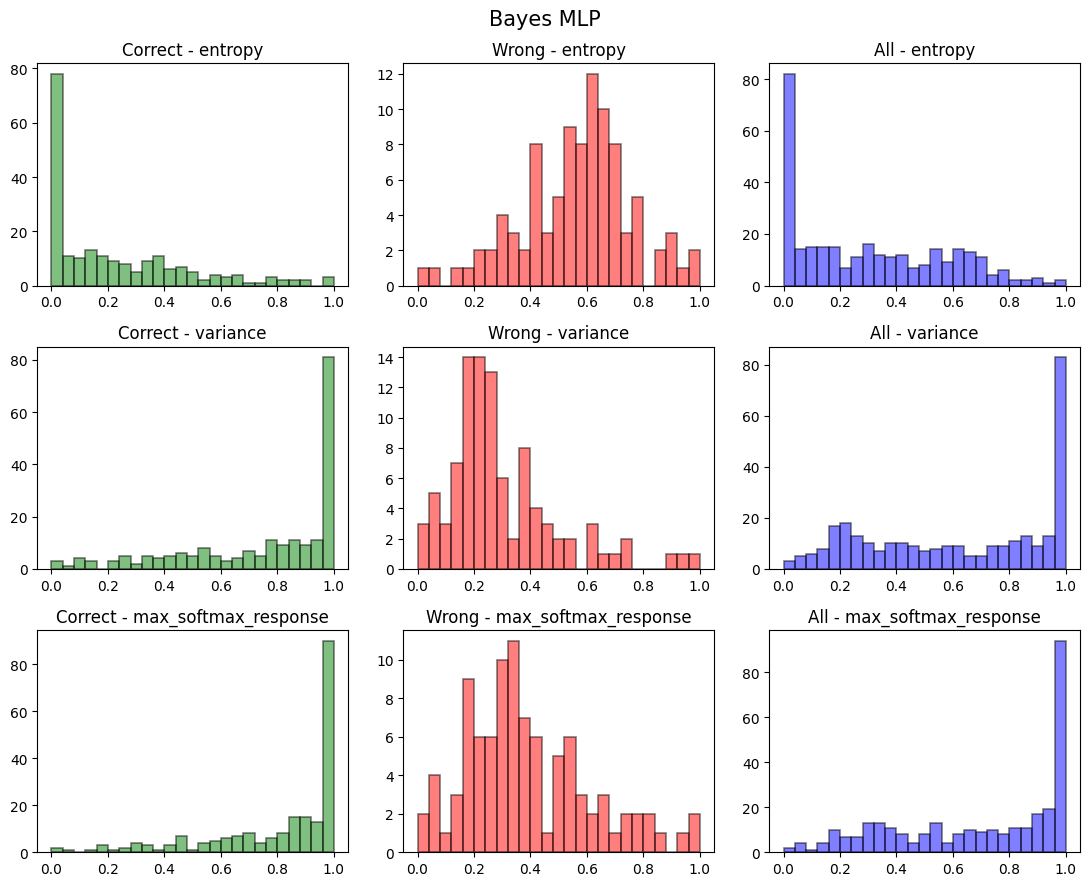

In [44]:
fig, ax = plt.subplots(len(model_unc._uncertainty_metrics.keys()), 3, figsize=(11, 9))
for ax, measure in zip(ax, model_unc._uncertainty_metrics.keys()):            # interessante
    ax[0].set_title(f"Correct - {measure}")
    ax[0].hist(uncertainties_bayes_collision['correct'][measure], color="green", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5)
    ax[1].set_title(f"Wrong - {measure}")
    ax[1].hist(uncertainties_bayes_collision['wrong'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5)
    ax[2].set_title(f"All - {measure}")
    ax[2].hist(uncertainties_bayes_collision['all'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5)
fig.suptitle("Bayes MLP", fontsize=15)      # per mettere il titolo all'intera figura
plt.tight_layout()


# Assignment #3:  Assess TAD algorithm performance via ROC curves

Consider that unconfident predictions will show an uncertainty above a given threshold

In [45]:
roc_dict = dict()
for confidence_metric in uncertainties_bayes_collision['correct'].keys():
    confidence = uncertainties_bayes_collision['all'][confidence_metric]
    if confidence_metric == 'entropy':
        confidence = 1 - confidence

    sens = list()
    fpr = list()
    cm_list = list()
    anomlay_indexes_dict = dict()
    acc_with_err = list()
    for threshold in np.arange(0, 1, 0.1):
        df_not_confident = df_features_collision_nonan.loc[np.array(confidence <= threshold)]
        tp = 0                                                                # true positive per quella threshold
        anomaly_indexes = list()
        for anomaly in collisions_init:
            for index, row in df_not_confident.iterrows():                    # serve a restituire indice e riga dei non confident (anomalie)
                if anomaly >= row['start'] and anomaly <= row['end']:
                    anomaly_indexes.append(index)
                    tp += 1

        cm_anomaly = np.zeros((2,2))
        n_sample = len(df_features_collision_nonan)
        n_not_collision = n_sample - len(collisions_init)
        n_detected = len(df_not_confident)

        fp = n_detected - tp
        fn = len(collisions_init) - tp
        tn = n_not_collision - fp
        tn1 = n_sample - n_detected - fn

        cm_anomaly[0, 0] = tn
        cm_anomaly[0, 1] = fp
        cm_anomaly[1, 0] = fn
        cm_anomaly[1, 1] = tp

        cm_list.append(cm_anomaly)
        recall = tp / (tp + fn)
        sens.append(recall)
        fpr.append(1 - tn / (tn + fp))
    roc_dict[confidence_metric] = (fpr, sens)

# In questo caso si considera una threshold sulla confidence piuttosto che una threshold sul risultato della predizione

In [ ]:
for confidence_metric in uncertainties_bayes_collision['correct'].keys():
    plt.plot(roc_dict[confidence_metric][0], roc_dict[confidence_metric][1], label=confidence_metric)
plt.legend()